In [ ]:
### Michelle Kouba
### VAE Analysis on Images

In [ ]:
# Mounting my drive
import os
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/My Drive/GitHub/dsc650/dsc650/assignments/assignment10')
!pwd

Mounted at /content/drive
/content/drive/My Drive/GitHub/dsc650/dsc650/assignments/assignment10


In [ ]:
# Importing needed libraries
import pandas as pd
import numpy as np
import keras
from keras import layers
import tensorflow as tf
import sys
import random
import matplotlib.pyplot as plt
import tensorflow.compat.v1.keras.backend as K
tf.compat.v1.disable_eager_execution()
from keras.datasets import mnist
from tensorflow.keras.models import Model
from pathlib import Path
from scipy.stats import norm

## Variational autoencoder (VAE) on MNIST images

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 28, 28, 32)   320         ['input_5[0][0]']                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 14, 14, 64)   18496       ['conv2d_10[0][0]']              
                                                                                                  
 conv2d_12 (Conv2D)             (None, 14, 14, 64)   36928       ['conv2d_11[0][0]']              
                                                                                            

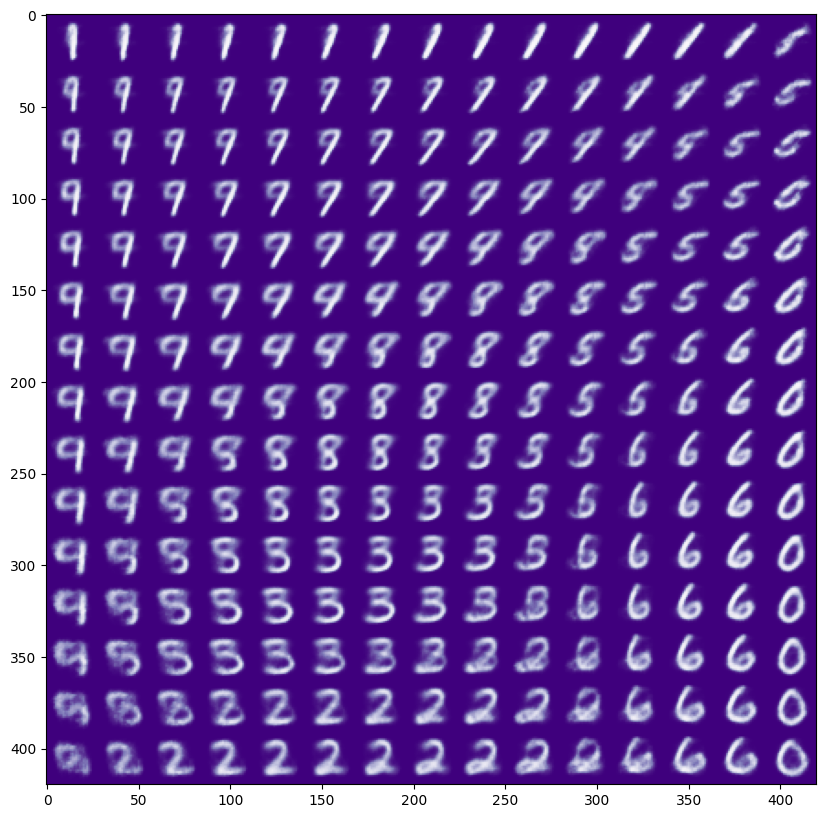

In [ ]:

# Implementing a variational autoencoder (VAE) on MNIST images
#VAE Encoder network
img_shape = (28, 28, 1)
batch_size = 16
# Dimensionality of the latent shape, a 2D image
latent_dim = 2
# Defining the input layer
input_img = keras.Input(shape=img_shape)
# Defining the model (with encoder layers and convolutional and dense layers as well)
x = layers.Conv2D(32, 3,padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x)
# Shape before flattening
shape_before_flattening = K.int_shape(x)
# Flattening layer
x = layers.Flatten()(x)
# Dense layer
x = layers.Dense(32, activation='relu')(x)
# The input image is being encoded into these two parameters (mean and log variance for latent variables)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Latent-shape-sampling function
# Function reshaping the vector (z) to the dimensions of the image and then use
# convolution layers to obtain the output image with the same shape of the original.
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=1.)
  return z_mean + K.exp(z_log_var) * epsilon
z = layers.Lambda(sampling)([z_mean, z_log_var])

# VAE decoder network, mapping latent shape points to images
# Z is feed into this input
decoder_input = layers.Input(K.int_shape(z)[1:])
# Upsamples of the input image
x = layers.Dense(np.prod(shape_before_flattening[1:]),activation='relu')(decoder_input)
# Reshapes z into a feature map of the same shape as the feature map just before flattening
x = layers.Reshape(shape_before_flattening[1:])(x)
# Using a Conv2dTranspose layer and a Conv2D layer to decode z into a feature map
# the same size as image input
x = layers.Conv2DTranspose(32, 3,padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(1, 3,padding='same', activation='sigmoid')(x)
# Instantiates the decoder model which turns the input into an image
decoder = Model(decoder_input, x)
# Applies the decoder to z to recover the decoded z
z_decoded = decoder(z)
# Custom layer used to compute the VAE loss
class CustomVariationalLayer(keras.layers.Layer):
  # Function that defines the VAE loss
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)
  # Function that applys the layer
  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x
# Custom layer to input and decode the latent variables
y = CustomVariationalLayer()([input_img, z_decoded])

# Training the VAE
# Defining the model
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()
# Loading the MNIST dataset
(x_train, _), (x_test, y_test) = mnist.load_data()
# Converting and normalizing the training data
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
# Converting and normalizing the testing data
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

#Training the model with no labels for either set (y=None) (VAE)
vae.fit(x=x_train, y=None,shuffle=True,epochs=10,batch_size=batch_size,validation_data=(x_test, None))

# Sampling a grid of points from the 2D latent space and decoding them to images (8.28)
# Size of grid squared
n=15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# Creating the images for the grid
for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
    x_decoded = decoder.predict(z_sample, batch_size=batch_size)
    digit = x_decoded[0].reshape(digit_size, digit_size)
        # Adding digits to the grid
    figure[i * digit_size: (i + 1) * digit_size,j * digit_size: (j + 1) * digit_size] = digit
 # Displaying the 15 by 15 image grid
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Purples_r')
fig = plt.gcf()
fig.savefig('results/VAE/15x15grid.png')
plt.show()